In [1]:
import numpy as np
from numpy import pi, sin
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def mu(x, y):
    z = np.zeros((len(y),len(x)))
    for i in range(len(x)):
        for j in range(len(y)):
            z[j][i] = -0.01 * sin(x[i]) + 0.05 * sin(y[j])
    return z

In [3]:
a = 6 * pi
b = 4 * pi
T = 10
hx = pi / 30
hy = hx
k = 1
eps = 1e-12

lm_min_x = (pi / a) ** 2 * k
lm_max_x = 4 * (k / hx ** 2)
lm_min_y = (pi / b) ** 2 * k
lm_max_y = 4 * (k / hy ** 2)

lambda_min = min(lm_min_x, lm_min_y)
lambda_max = max(lm_max_x, lm_max_y)

tau_min = 2 / lambda_max
tau_max = 2 / lambda_min

# не 1/4 из-за 2-мерного случая
S = int(np.ceil(1 / 8 * np.log(1 / eps) * np.log(lambda_max / lambda_min)))
t = np.array([np.exp(np.log(tau_min) + (i - 1) / (S - 1) * np.log(tau_max / tau_min)) for i in range(S)])

x = np.arange(0, a + hx, hx)
y = np.arange(0, b + hy, hy)

u = np.zeros((len(t) + 1, len(y), len(x)))
u[0] = mu(x, y)
for i in range(1, len(t)):
    u[i, 0, :]  = np.squeeze(mu(x, [0]))
    u[i, -1, :] = np.squeeze(mu(x, [b]))
    u[i, :, 0]  = np.squeeze(mu([0], y))
    u[i, :, -1] = np.squeeze(mu([a], y))

L_x = np.zeros((len(x), len(x)))
for n in range(1, len(x) - 1):
    L_x[n][n - 1] = 1
    L_x[n][n] = -2
    L_x[n][n + 1] = 1
L_x *= k / hx ** 2

L_y = np.zeros((len(y),len(y)))
for n in range(1, len(y) - 1):
    L_y[n][n - 1] = 1
    L_y[n][n] = -2
    L_y[n][n + 1] = 1
L_y *= k / hy ** 2

du_list = []
for i in range(len(t)):
    tau  = t[i]
    Px = np.eye(len(x)) - tau * L_x / 2;
    Py = np.eye(len(y)) - tau * L_y / 2;
    F = u[i] @ L_x.T + L_y @ u[i]
    F[0, :] = np.zeros(F[0, :].shape)
    F[-1, :] = np.zeros(F[-1, :].shape)
    F[:, 0] = np.zeros(F[:, 0].shape)
    F[:, -1] = np.zeros(F[:, -1].shape)
    v = np.linalg.solve(Px, F.T)
    du_list.append(np.linalg.solve(Py, v.T))
    u[i + 1] = u[i] + tau * du_list[-1]

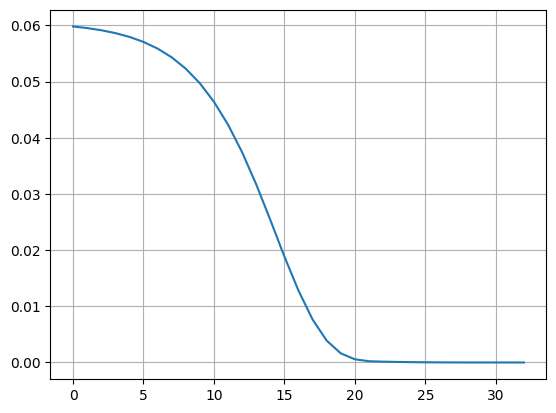

In [4]:
plt.plot([np.amax(abs(t)) for t in du_list])
plt.grid(True)

In [5]:
matplotlib.rcParams['animation.embed_limit'] = 2**128

def animate(n):
    ax.clear()
    ax.set_zlim(-0.1, 0.1)
    surf = ax.plot_surface(X, Y, u[n], cmap="Blues", linewidth=0, antialiased=False)
    return surf,

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.grid(True)
ax.view_init(20, 310)
X, Y = np.meshgrid(x, y)
anim = FuncAnimation(fig, animate, frames=len(t), interval=1)
plt.close()
HTML(anim.to_jshtml())